### Import

In [1]:
import numpy as np
import xarray as xr
import pymannkendall as mk
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                                      # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/HASIA_ch2_analysis/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/HASIA_ch2_analysis/figs/'      # figures


### Run a simple [example](https://pypi.org/project/pymannkendall/) with single 1D array

In [3]:
## simple example using a 1D array
# Data generation for analysis
data = np.random.rand(360,1)

# run test
result = mk.original_test(data)
# Output are like this:
print('Generic output:', result)

# the output is a named tuple, so you can call by name for specific result:
print('Call for specific result:', result.slope)

# or, you can directly unpack your results like this:
trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(data)
print('Directly unpack results:', slope)

Generic output: Mann_Kendall_Test(trend='no trend', h=False, p=0.20636966348615848, z=-1.2636110555932554, Tau=-0.04463014546580006, s=-2884.0, var_s=5205500.0, slope=-0.00018619703479794483, intercept=0.5716446221589935)
Call for specific result: -0.00018619703479794483
Directly unpack results: -0.00018619703479794483


### Now let's run a more complicated example with 3D data

In [4]:
start_date = '2016-01-01 00:00'
end_date = '2016-12-31 18:00'

# Select lat/lon grid
lonmin = 20
lonmax = 110
latmin = 0
latmax = 55

# now let's load 3D data
## upper level data
rename_dict_upper = {'z': 'H', 
                     'u': 'U250', 
                     'v':'V250', 
                     'q': 'QV',
                     'latitude': 'lat',
                     'longitude': 'lon'}

filepath = path_to_data + 'ERA5/huvq/anomalies/daily_filtered_anomalies_huvq_2016.nc'
ds = xr.open_dataset(filepath)
ds = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), time=slice(start_date, end_date), level=250.)
ds = ds.rename(rename_dict_upper) # rename vars to be more convenient
ds = ds.assign(H=lambda ds: ds.H/(9.80665)) # convert to geopotential height (m)
ds

<xarray.Dataset>
Dimensions:    (lat: 111, lon: 181, time: 366)
Coordinates:
  * lat        (lat) float32 55.0 54.5 54.0 53.5 53.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon        (lon) float32 20.0 20.5 21.0 21.5 ... 108.5 109.0 109.5 110.0
    level      float64 250.0
  * time       (time) datetime64[ns] 2016-01-01T09:00:00 ... 2016-12-31T09:00:00
    dayofyear  (time) int64 ...
Data variables:
    H          (time, lat, lon) float64 153.9 151.3 147.7 ... 15.11 14.86 14.63
    QV         (time, lat, lon) float64 ...
    U250       (time, lat, lon) float64 ...
    V250       (time, lat, lon) float64 ...

### The wrapped function for xarray
--referenced https://stackoverflow.com/questions/57419541/how-to-use-apply-ufunc-with-numpy-digitize-for-each-image-along-time-dimension-o

In [5]:
def _new_mk_original(ds):
    # Wrapper around scipy linregress to use in apply_ufunc
    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(ds)
    return np.array([p, slope, intercept])

def mk_original_test_ufunc(ds, dims=['time']):
    '''Wrapped pymannkendall to calculate pval, slope, and intercept in xr.dataset form'''
    return xr.apply_ufunc(_new_mk_original, # function you want to run
                          ds, # now arguments in order for that function
                          input_core_dims=[dims], # list with one entry per arg of dims you don't want broadcasted
                          output_core_dims=[["parameter"]], # size out output
                          vectorize=True,
                          dask="parallelized",
                          output_dtypes=['float64'],
                          dask_gufunc_kwargs={'output_sizes': {"parameter": 3}}
                         )


In [6]:
%%time
# let's run the test on the ds now
# create chunked dask version of data
data_chunked = ds.H.chunk({'time': -1})
# run on single variable
results = mk_original_test_ufunc(data_chunked, dims=['time'])
slope = results.isel(parameter=0)
print(slope)

<xarray.DataArray 'H' (lat: 111, lon: 181)>
dask.array<getitem, shape=(111, 181), dtype=float64, chunksize=(111, 181), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 55.0 54.5 54.0 53.5 53.0 52.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 20.0 20.5 21.0 21.5 22.0 ... 108.5 109.0 109.5 110.0
    level    float64 250.0
CPU times: user 197 ms, sys: 2.02 ms, total: 199 ms
Wall time: 197 ms


In [7]:
%%time
# compute slope if you used data_chunk
slope = slope.compute()

CPU times: user 9min, sys: 1.55 s, total: 9min 2s
Wall time: 9min 1s


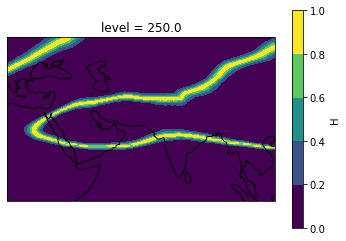

In [8]:
ax = plt.axes(projection=ccrs.PlateCarree())

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()